# PaddlePaddle for Segmentation
PaddleSeg supports multiple segmentation tasks as semantic segmentation, interactive segmentation, Panoptic segmentation, Image matting etc, as an example let us use semantic segmentation to classify each possible pixel in an image and video.

Since we would be using paddlepaddle on cuda we need to install paddlepaddle-gpu. We will be using it on colab, its command is

In [ ]:
!pip install paddlepaddle-gpu==2.4.2.post117 -f https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://www.paddlepaddle.org.cn/whl/linux/mkl/avx/stable.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.3/557.3 MB 2.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 17.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.2/383.2 kB 37.5 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-api-core 2.11.1 requires protobuf!=3.20.0,!=3.20.1,!=4.21.0,!=4.21.1,!=4.21.2,!=4.21.3,!=4.21.4,!=4.21.5,<5.0.0.dev0,>=3.19.5, but you have protobuf 3.20.0 which is incompatible.
google-cloud-bigquery 3.10.0 requires protobuf!=3.20.0,!

Followed by installing paddleseg as

In [ ]:
!pip install paddleseg

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 424.3/424.3 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 83.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.5/60.5 MB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 210.5/210.5 kB 27.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 71.1 MB/s eta 0:00:00
  Attempting uninstall: opencv-python
    Found existing installation: opencv-python 4.7.0.72
    Uninstalling opencv-python-4.7.0.72:
      Successfully uninstalled opencv-python-4.7.0.72


For using PaddleSeg we need to clone the repository as

In [ ]:
!git clone https://github.com/PaddlePaddle/PaddleSeg.git

Cloning into 'PaddleSeg'...
remote: Enumerating objects: 25506, done.
remote: Total 25506 (delta 0), reused 0 (delta 0), pack-reused 25506
Receiving objects: 100% (25506/25506), 349.17 MiB | 25.30 MiB/s, done.
Resolving deltas: 100% (16569/16569), done.


In [ ]:
cd PaddleSeg

/content/PaddleSeg


Install the requirements as


In [ ]:
pip install -r requirements.txt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Import the necessary libraries

In [ ]:
import os
from urllib.request import urlretrieve
from zipfile import ZipFile
import shutil
import cv2
from matplotlib import pyplot as plt

import numpy as np
import time
import codecs
import yaml
from paddle.inference import create_predictor, PrecisionType
from paddle.inference import Config as PredictConfig
import paddleseg.transforms as T
from paddleseg.deploy.infer import DeployConfig
from paddleseg.cvlibs import manager
from PIL import Image as PILImage
import scipy.misc as misc

/content/PaddleSeg/paddleseg/models/layers/ms_deformable_attention.py:95: DeprecationWarning: invalid escape sequence '\s'
  """
/content/PaddleSeg/paddleseg/models/losses/rmi_loss.py:73: DeprecationWarning: invalid escape sequence '\i'
  """


Define some helper function that will be used later for downloading the necessary files.

In [ ]:
def download_and_unzip(url, save_path):
    print(f"Downloading and extracting assets....", end="")

    # Downloading zip file using urllib package.
    urlretrieve(url, save_path)

    try:
        # Extracting zip file using the zipfile package.
        with ZipFile(save_path) as z:
            # Extract ZIP file contents in the same directory.
            z.extractall(os.path.split(save_path)[0])

        print("Done")

    except Exception as e:
        print("\nInvalid file.", e)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Use the predefined helper functions.

In [ ]:
URL = r"https://www.dropbox.com/s/goxabsf8cl0ohp5/segmentation.zip?dl=1"
asset_zip_path = os.path.join(os.getcwd(), "segmentation.zip")
# Download if assest ZIP does not exists.
if not os.path.exists(asset_zip_path):
    download_and_unzip(URL, asset_zip_path)

The code below will create one folder with the same name as the configuration yml file in the inference_model folder containing 4 files namely `infer_cfg.yml`, `model.pdiparams`, `model.pdiparams.info` and `model.pdmodel`

The main purpose of these files are:
1. `model.pdiparams`: contains model weights
2. `model.pdiparams.info`: contains information about parameters
3. `model.pdmodel`: contains model structure description
4. `infer_cfg.yml`: preprocessing configuration file


In [ ]:
!python tools/export.py \
       --config configs/hrnet_w48_contrast/HRNet_W48_contrast_cityscapes_1024x512_60k.yml \
       --model_path segmentation/hrnet_seg.pdparams \
       --input_shape 1 3 1024 512 \
       --save_dir output/inference_models

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

Inference using the exported model on image

In [ ]:
!python deploy/python/infer.py \
    --config output/inference_models/deploy.yaml \
    --image_path segmentation/segmentation_input_image.png

/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:121: DeprecationWarning: pkg_resources is deprecated as an API
  warnings.warn("pkg_resources is deprecated as an API", DeprecationWarning)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr/local/lib/python3.10/dist-packages/pkg_resources/__init__.py:2870: DeprecationWarning: Deprecated call to `pkg_resources.declare_namespace('google.cloud')`.
Implementing implicit namespace packages (as specified in PEP 420) is preferred to `pkg_resources.declare_namespace`. See https://setuptools.pypa.io/en/latest/references/keywords.html#keyword-namespace-packages
  declare_namespace(pkg)
/usr

Now that we have the segmentation map we can overlap this map on the input image as


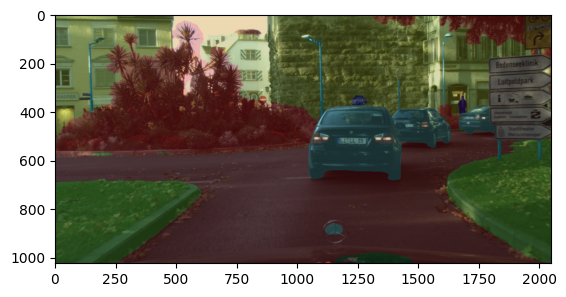

In [ ]:
image=cv2.imread("segmentation/segmentation_input_image.png")
segPred=cv2.imread("output/segmentation_input_image.png")
seg_weight=0.3
predBlend = cv2.addWeighted(image, 1 - seg_weight, segPred, seg_weight, 0)
plt.imshow(predBlend[:,:,::-1])
plt.show()

`cv2.addWeighted` is a function in OpenCV that blends or merges two images according to specified weights. Here image is the input image used and segPred is the segmentation map and we are performing a weighted addition between input image and segmentation map according to seg_weight.

Now that we can get the segmentation map using CLI let us use code to do the same.

In [ ]:
def get_pseudo_color_map(pred, name, color_map=None):
    pred_mask = PILImage.fromarray(pred.astype(np.uint8), mode='P')
    if color_map is None:
        color_map = get_color_map_list(256)
    pred_mask.putpalette(color_map)
    pred_mask.save(name)

def get_color_map_list(num_classes, custom_color=None):
    num_classes += 1
    color_map = num_classes * [0, 0, 0]
    for i in range(0, num_classes):
        j = 0
        lab = i
        while lab:
            color_map[i * 3] |= (((lab >> 0) & 1) << (7 - j))
            color_map[i * 3 + 1] |= (((lab >> 1) & 1) << (7 - j))
            color_map[i * 3 + 2] |= (((lab >> 2) & 1) << (7 - j))
            j += 1
            lab >>= 3
    color_map = color_map[3:]

    if custom_color:
        color_map[:len(custom_color)] = custom_color
    return color_map

Prediction is done in this class along with preprocessing and postprocessing.

In [ ]:
class Predictor:
    def __init__(self, config, name='frame.png'):
        self.name = name
        self.cfg = DeployConfig(config)
        self._init_base_config()
        self._init_gpu_config()
        self.predictor = create_predictor(self.pred_cfg)

    def _init_base_config(self):
        self.pred_cfg = PredictConfig(self.cfg.model, self.cfg.params)
        self.pred_cfg.enable_memory_optim()
        self.pred_cfg.switch_ir_optim(True)

    def _init_gpu_config(self):
        self.pred_cfg.enable_use_gpu(100, 0)

    def run(self, img_path):
        input_names = self.predictor.get_input_names()
        input_handle = self.predictor.get_input_handle(input_names[0])
        output_names = self.predictor.get_output_names()
        output_handle = self.predictor.get_output_handle(output_names[0])
        results = []
        frame = img_path
        data = np.array([self._preprocess(frame)])
        input_handle.reshape(data.shape)
        input_handle.copy_from_cpu(data)
        self.predictor.run()
        results = output_handle.copy_to_cpu()
        self._postprocess(results)

        return cv2.imread(self.name)

    def _preprocess(self, img):
        data = {}
        data["img"] = img
        return self.cfg.transforms(data)["img"]

    def _postprocess(self, results):
        get_pseudo_color_map(results[0], self.name)


Lets us use the class

In [ ]:
image_inference = Predictor("output/inference_models/deploy.yaml")
prediction = image_inference.run("segmentation/segmentation_input_image.png")

Now overlap segmentation map on image to get final prediction.

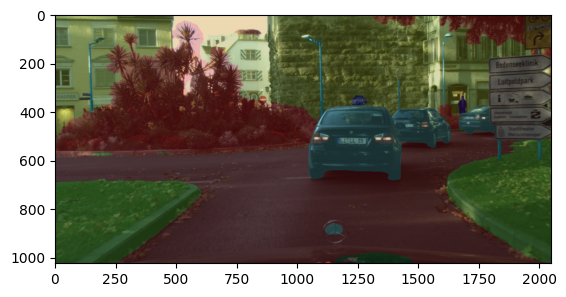

In [ ]:
image=cv2.imread("segmentation/segmentation_input_image.png")
segPred=cv2.imread("frame.png")
seg_weight=0.3
predBlend = cv2.addWeighted(image, 1 - seg_weight, segPred, seg_weight, 0)
plt.imshow(predBlend[:,:,::-1])
plt.show()

For video inference we will be using the previously defined codes for per frame prediction.

The driver code used to call the previous functions for each frame.

In [ ]:
def video_inference(video, seg_weight, PaddleEngine, video_name):
    video = cv2.VideoCapture(video)
    i = 0
    while True:
        ret, frame = video.read()
        if not ret:
            break
        if i == 0:
            shape = frame.shape
            out = cv2.VideoWriter(
                video_name,
                cv2.VideoWriter_fourcc(*"mp4v"),
                video.get(cv2.CAP_PROP_FPS),
                (shape[1], shape[0]),
            )

        segPred = PaddleEngine.run(frame)
        frame_resized = frame
        predBlend = cv2.addWeighted(
            frame_resized, 1 - seg_weight, segPred, seg_weight, 0
        )
        out.write(predBlend)
        i += 1

    video.release()
    out.release()


The `CONFIG` and `VIDEO` paths to point to the exported model's deployment file and video file for inference respectively.

In [ ]:
CONFIG = "output/inference_models/deploy.yaml"
VIDEO = "segmentation/segmentation_input_video.mp4"
video_inference(VIDEO, 0.3, Predictor(CONFIG), "segmentation_output_video.mp4")

## Conclusion
In this notebook we used a pretrained PaddleSeg model for image and video segmentation. By changing the config file and weights file while exporting we can easily use other models available on PaddleSeg.

## References
- https://github.com/PaddlePaddle/PaddleSeg